<a href="https://colab.research.google.com/github/MatheoCruz/BLR_perovskite/blob/main/Preprocesamiento_BD_Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Cargamos las librerias

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.stats import norm
from sklearn.model_selection import KFold
from scipy import stats
import seaborn as sns

Se vrean las funciones a usar basado en las caracteristicas y necesidades de la base de datos

In [ ]:
#functions
def es_rango(valor):
    if type(valor) == str and '-' in valor:
        return True
    else:
        return False

In [ ]:
#Import data
df = pd.read_excel("/content/drive/MyDrive/Deep Learning/TG/codificacion_reducido.xlsx")
df = df.drop(['Ref', 'Note'], axis=1)
df = df.rename(columns={'Band gap': 'Band_gap'})

In [ ]:
#Data conditioning
df = df.replace('--', np.nan)
df['Grain_size'] = df['Grain_size'].str.replace('nm', '').str.strip()
df['Grain_size'] = df['Grain_size'].str.replace(',', '.')
indices_rangos = np.nonzero(df['Grain_size'].apply(es_rango).values)[0]
for indice in indices_rangos:
  valores = df["Grain_size"][indice].split("-")
  promedio = (float(valores[0]) + float(valores[1])) / 2
  df["Grain_size"][indice] = promedio
df['Grain_size'] = df['Grain_size'].astype(float)

<ipython-input-5-5541ba0bc047>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Grain_size"][indice] = promedio


In [ ]:
#revision de datos faltantes
N,n = df.shape
num_zeros=[]
for i in range(n-1):
  print("Datos faltante para ",df.columns[i+1],"=", df[df.columns[i+1]].isna().sum())

Datos faltante para  FA = 0
Datos faltante para  Cs = 0
Datos faltante para  Pb = 0
Datos faltante para  Sn = 0
Datos faltante para  Br = 0
Datos faltante para  Cl = 0
Datos faltante para  I = 0
Datos faltante para  Band_gap = 0
Datos faltante para  DeltaH = 0
Datos faltante para  DeltaL = 0
Datos faltante para  Grain_size = 158
Datos faltante para  Thickness = 0
Datos faltante para  PCE = 0
Datos faltante para  Voc = 0
Datos faltante para  Jsc = 0
Datos faltante para  FF = 0


In [ ]:
# Reduccion y construccion de la nueva data
#entradas
A = df.MA - df.FA - df.Cs
B = df.Pb - df.Sn
X = df.I + df.Cl - df.Br
Band_gap = df.Band_gap
DeltaH = df.DeltaH
DeltaL = df.DeltaL
Grain_size = df.Grain_size/1000
Thickness = df.Thickness/1000
#salidas
Jsc = df.Jsc
FF = df.FF
PCE = df.PCE
Voc = df.Voc

In [ ]:
#new data frame
data = {'A':A ,'B':B, 'X':X, 'Band_gap':Band_gap, 'DeltaH':DeltaH, 'DeltaL':DeltaL, 'Grain_size':Grain_size, 'Thickness':Thickness, 'PCE':PCE, 'Voc':Voc, 'Jsc':Jsc, 'FF':FF}
data = pd.DataFrame(data)
data_copy = {'A':A ,'B':B, 'X':X, 'Band_gap':Band_gap, 'DeltaH':DeltaH, 'DeltaL':DeltaL, 'Grain_size':Grain_size, 'Thickness':Thickness, 'PCE':PCE, 'Voc':Voc, 'Jsc':Jsc, 'FF':FF}
data_copy = pd.DataFrame(data)

In [ ]:
data_parcial = {'DeltaH':DeltaH, 'DeltaL':DeltaL, 'Grain_size':Grain_size}
data_parcial = pd.DataFrame(data_parcial)

In [ ]:
count = np.count_nonzero(data_parcial['Grain_size'] < 0.1)
print("valores fuera de rango para grainsize" , count)

valores fuera de rango para grainsize 3


Se limitan los valores

In [ ]:
data_parcial_copy = {'DeltaH':DeltaH, 'DeltaL':DeltaL, 'Grain_size':Grain_size}
data_parcial_copy = pd.DataFrame(data_parcial_copy)
data_parcial_copy['Grain_size'] = np.where((data_parcial_copy['Grain_size'] < 0.1), data_parcial_copy['Grain_size']*10, data_parcial_copy['Grain_size'])
data_parcial_copy['Grain_size'] = np.where((data_parcial_copy['Grain_size'] < 0.1), data_parcial_copy['Grain_size']*10, data_parcial_copy['Grain_size'])
data_parcial_copy['DeltaH'] = np.where((data_parcial_copy['DeltaH'] < 0), -data_parcial_copy['DeltaH'], data_parcial_copy['DeltaH'])
data_parcial_copy['DeltaL'] = np.where((data_parcial_copy['DeltaL'] < 0), -data_parcial_copy['DeltaL'], data_parcial_copy['DeltaL'])

Se extraen la grilla por medio de un kernel usando seaborn y su correspondiente grafica de densidad de probabilidad

<ipython-input-22-d393762c9ab7>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  kde = sns.distplot(data_parcial_copy[data_parcial_copy.columns[j]], kde=True, hist = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-22-d393762c9ab7>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Pl

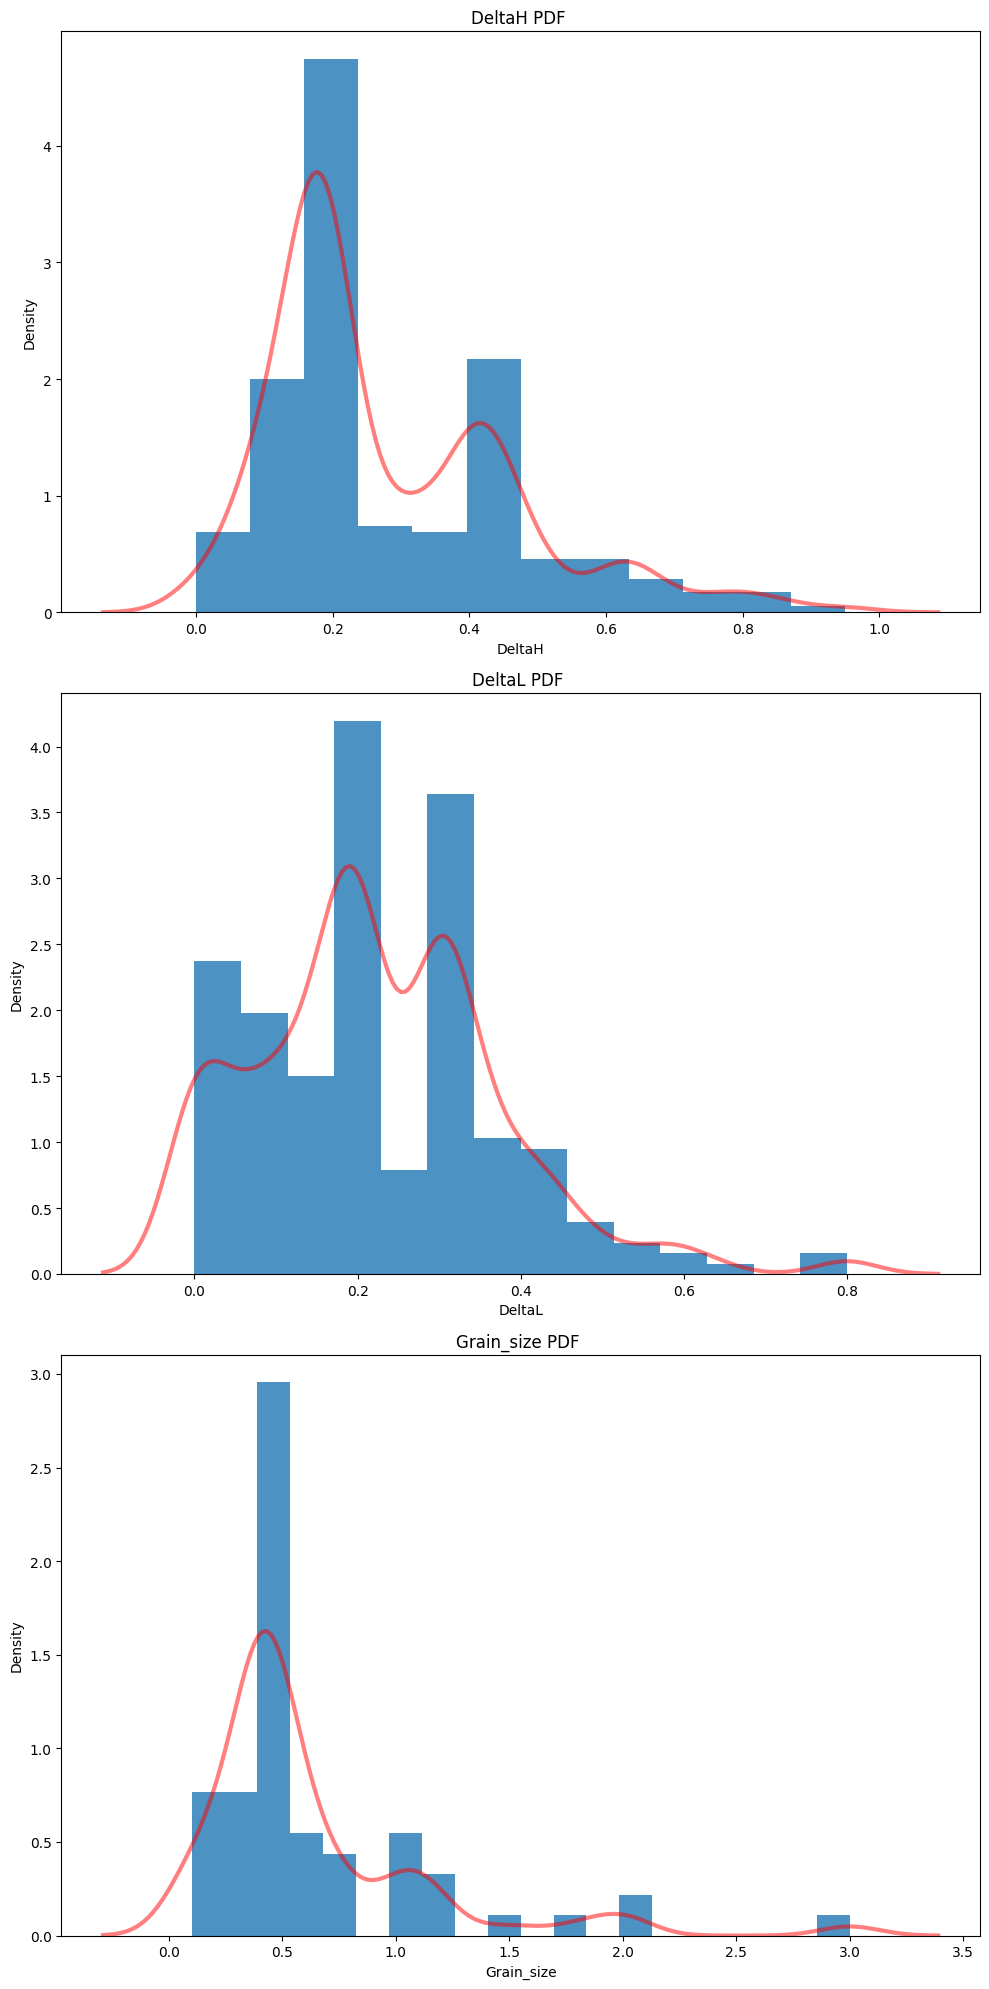

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
kde_x_copy = []
kde_y_copy = []
# Graficar el primer histograma
for j in range(0,3):
  kde = sns.distplot(data_parcial_copy[data_parcial_copy.columns[j]], kde=True, hist = True,
               kde_kws={"linewidth": 3, "color": "red", "alpha": 0.5, "bw":0.25},
               hist_kws={"alpha": 0.8},
               ax=axes[j])
  grid = kde.get_lines()[0].get_data()
  grid_x = {data_parcial.columns[j]:grid[0]}
  grid_y = {data_parcial.columns[j]:grid[1]}
  kde_x_copy.append(grid_x)
  kde_y_copy.append(grid_y)
  axes[j].set_title(data_parcial.columns[j] +" PDF ")
  plt.tight_layout()
plt.show()

In [ ]:
#Extraction of useful information
mean =  {'mean_A':np.mean(A), 'mean_B':np.mean(B), 'mean_X':np.mean(X), 'mean_Band_gap':np.mean(Band_gap), 'mean_DeltaH':np.mean(DeltaH), 'mean_DeltaL':np.mean(DeltaL), 'mean_Grain_size':np.mean(Grain_size), 'mean_Thickness':np.mean(Thickness), 'mean_PCE':np.mean(PCE), 'mean_Voc':np.mean(Voc), 'mean_Jsc':np.mean(Jsc), 'mean_FF':np.mean(FF)}
std = {'std_A':np.std(A), 'std_B':np.std(B), 'std_X':np.std(X), 'std_Band_gap':np.std(Band_gap), 'std_DeltaH':np.std(DeltaH), 'std_DeltaL':np.std(DeltaL), 'std_Grain_size':np.std(Grain_size), 'std_Thickness':np.std(Thickness),'std_PCE':np.std(PCE), 'std_Voc':np.std(Voc), 'std_Jsc':np.std(Jsc), 'std_FF':np.std(FF)}

In [ ]:
data_copy['Grain_size'] = data_parcial_copy['Grain_size']
data_copy['DeltaH'] = data_parcial_copy['DeltaH']
data_copy['DeltaL'] = data_parcial_copy['DeltaL']

Se crea el archivo .csv con la informacion generada del preprocesamiento

In [ ]:
#Eliminacion de las filas con datos faltantes y generando nuevo archivo csv
data_copy = data_copy.dropna()
data_copy.to_csv("data_training_copy.csv", index = False)
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 219
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   A           63 non-null     float64
 1   B           63 non-null     float64
 2   X           63 non-null     float64
 3   Band_gap    63 non-null     float64
 4   DeltaH      63 non-null     float64
 5   DeltaL      63 non-null     float64
 6   Grain_size  63 non-null     float64
 7   Thickness   63 non-null     float64
 8   PCE         63 non-null     float64
 9   Voc         63 non-null     float64
 10  Jsc         63 non-null     float64
 11  FF          63 non-null     float64
dtypes: float64(12)
memory usage: 6.4 KB


In [ ]:
kde_X_copy = {'DeltaH':kde_x_copy[0]['DeltaH'], 'DeltaL':kde_x_copy[1]['DeltaL'], 'Grain_size':kde_x_copy[2]['Grain_size']}
kde_X_copy = pd.DataFrame(kde_X_copy)
kde_Y_copy = {'DeltaH':kde_y_copy[0]['DeltaH'], 'DeltaL':kde_y_copy[1]['DeltaL'], 'Grain_size':kde_y_copy[2]['Grain_size']}
kde_Y_copy = pd.DataFrame(kde_Y_copy)
kde_X_copy.to_csv("kde_X_copy.csv", index = False)
kde_Y_copy.to_csv('kde_Y_copy.csv', index = False)